In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint

In [2]:
df = pd.read_parquet("data.parquet", engine='pyarrow')

In [3]:
df.shape
print(df)

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27
...                        ...       ...  ...
2022-06-30 15:26:00   0.240701  0.214758   28
2022-06-30 15:27:00   0.240875  0.216558   28
2022-06-30 15:28:00   0.242115  0.216794   28
2022-06-30 15:29:00   0.243426  0.216455   28
2022-06-30 15:30:00   0.241907  0.216081   28

[690512 rows x 3 columns]


## Data Cleaning

In [4]:
columns = df.columns
columns

Index(['banknifty', 'nifty', 'tte'], dtype='object')

In [5]:
df.isnull().mean()

banknifty    0.002172
nifty        0.002896
tte          0.000000
dtype: float64

In [6]:
df[df.isnull().any(axis=1)]

,banknifty,nifty,tte
time,,,
2021-01-01 12:39:00,0.256850,NaN,27
2021-01-01 21:25:00,NaN,0.178049,27
2021-01-02 00:18:00,0.255651,NaN,27
2021-01-02 01:48:00,NaN,0.178049,27
2021-01-02 03:29:00,NaN,0.178049,27
...,...,...,...
2022-06-29 21:59:00,NaN,0.214376,29
2022-06-29 22:40:00,NaN,0.214376,29
2022-06-29 22:59:00,0.243723,NaN,29


In [7]:
df.dtypes

banknifty    float64
nifty        float64
tte            int32
dtype: object

In [8]:
## indices with missing values
df[df.isnull().any(axis=1)].index

DatetimeIndex(['2021-01-01 12:39:00', '2021-01-01 21:25:00',
               '2021-01-02 00:18:00', '2021-01-02 01:48:00',
               '2021-01-02 03:29:00', '2021-01-02 04:11:00',
               '2021-01-02 04:25:00', '2021-01-02 12:38:00',
               '2021-01-02 21:20:00', '2021-01-02 22:15:00',
               ...
               '2022-06-29 03:49:00', '2022-06-29 04:18:00',
               '2022-06-29 12:40:00', '2022-06-29 14:41:00',
               '2022-06-29 21:27:00', '2022-06-29 21:59:00',
               '2022-06-29 22:40:00', '2022-06-29 22:59:00',
               '2022-06-30 07:07:00', '2022-06-30 12:32:00'],
              dtype='datetime64[ns]', name='time', length=3499, freq=None)

In [9]:
from sklearn.impute import KNNImputer

In [10]:
# Create a KNN imputer with 10 neighbors
imputer = KNNImputer(n_neighbors=10,weights='distance')

# Impute missing values in the numerical columns (nifty and banknifty)
df_imputed = pd.DataFrame(imputer.fit_transform(df))

In [11]:
df_imputed

,0,1,2
0,0.286058,0.199729,27.0
1,0.285381,0.200433,27.0
2,0.284233,0.200004,27.0
3,0.286104,0.199860,27.0
4,0.285539,0.198951,27.0
...,...,...,...
690507,0.240701,0.214758,28.0
690508,0.240875,0.216558,28.0
690509,0.242115,0.216794,28.0
690510,0.243426,0.216455,28.0


In [12]:
df_imputed.columns = columns
df_imputed.index = df.index
df_imputed

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0
2021-01-01 09:16:00,0.285381,0.200433,27.0
2021-01-01 09:17:00,0.284233,0.200004,27.0
2021-01-01 09:18:00,0.286104,0.199860,27.0
2021-01-01 09:19:00,0.285539,0.198951,27.0
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28.0
2022-06-30 15:27:00,0.240875,0.216558,28.0
2022-06-30 15:28:00,0.242115,0.216794,28.0


In [13]:
df_imputed.compare(df, keep_equal=True)

banknifty               nifty          
                         self     other      self     other
time                                                       
2021-01-01 12:39:00  0.256850  0.256850  0.161159       NaN
2021-01-01 21:25:00  0.255651       NaN  0.178049  0.178049
2021-01-02 00:18:00  0.255651  0.255651  0.183953       NaN
2021-01-02 01:48:00  0.255651       NaN  0.178049  0.178049
2021-01-02 03:29:00  0.255651       NaN  0.178049  0.178049
...                       ...       ...       ...       ...
2022-06-29 21:59:00  0.254321       NaN  0.214376  0.214376
2022-06-29 22:40:00  0.254321       NaN  0.214376  0.214376
2022-06-29 22:59:00  0.243723  0.243723  0.193299       NaN
2022-06-30 07:07:00  0.254321       NaN  0.214376  0.214376
2022-06-30 12:32:00  0.241878  0.241878  0.169143       NaN

[3499 rows x 4 columns]

In [14]:
#just for using shorter name of dataframe
df = df_imputed
df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0
2021-01-01 09:16:00,0.285381,0.200433,27.0
2021-01-01 09:17:00,0.284233,0.200004,27.0
2021-01-01 09:18:00,0.286104,0.199860,27.0
2021-01-01 09:19:00,0.285539,0.198951,27.0
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28.0
2022-06-30 15:27:00,0.240875,0.216558,28.0
2022-06-30 15:28:00,0.242115,0.216794,28.0


## Base Model

In [15]:
df = df[(df.index.time >= pd.to_datetime('09:15:00').time()) & (df.index.time <= pd.to_datetime('15:30:00').time())]
df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0
2021-01-01 09:16:00,0.285381,0.200433,27.0
2021-01-01 09:17:00,0.284233,0.200004,27.0
2021-01-01 09:18:00,0.286104,0.199860,27.0
2021-01-01 09:19:00,0.285539,0.198951,27.0
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28.0
2022-06-30 15:27:00,0.240875,0.216558,28.0
2022-06-30 15:28:00,0.242115,0.216794,28.0


In [16]:
df.fillna(method='ffill', inplace=True)
df.shape

C:\Windows\Temp\ipykernel_1476\2983330719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


(180856, 3)

In [17]:
df['spread'] = df['banknifty'] - df['nifty']
df

C:\Windows\Temp\ipykernel_1476\439994901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spread'] = df['banknifty'] - df['nifty']


,banknifty,nifty,tte,spread
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0,0.086329
2021-01-01 09:16:00,0.285381,0.200433,27.0,0.084948
2021-01-01 09:17:00,0.284233,0.200004,27.0,0.084229
2021-01-01 09:18:00,0.286104,0.199860,27.0,0.086244
2021-01-01 09:19:00,0.285539,0.198951,27.0,0.086588
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28.0,0.025943
2022-06-30 15:27:00,0.240875,0.216558,28.0,0.024317
2022-06-30 15:28:00,0.242115,0.216794,28.0,0.025321


In [18]:
df['spread_zscore'] = zscore(df['spread'])

C:\Windows\Temp\ipykernel_1476\3659349376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spread_zscore'] = zscore(df['spread'])


In [19]:
def calculate_profit_loss(spread, tte):
    return spread*((tte)**0.7)

In [20]:
base_PL = pd.DataFrame()
base_PL['PL'] = calculate_profit_loss(df['spread'], df['tte'])
df['PL'] = calculate_profit_loss(df['spread'], df['tte'])

C:\Windows\Temp\ipykernel_1476\559452159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PL'] = calculate_profit_loss(df['spread'], df['tte'])


In [21]:
base_PL

,PL
time,
2021-01-01 09:15:00,0.867184
2021-01-01 09:16:00,0.853317
2021-01-01 09:17:00,0.846089
2021-01-01 09:18:00,0.866325
2021-01-01 09:19:00,0.869786
...,...
2022-06-30 15:26:00,0.267320
2022-06-30 15:27:00,0.250560
2022-06-30 15:28:00,0.260910


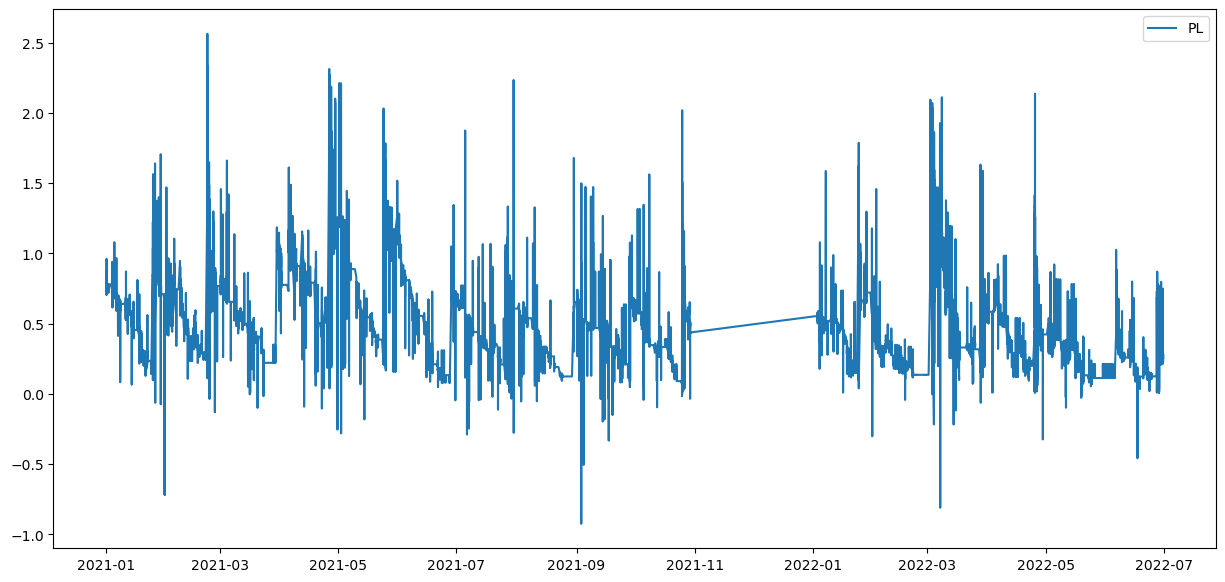

In [22]:
plt.figure(figsize = (15, 7))
plt.plot(base_PL)
plt.legend(["PL"])
plt.show()

In [23]:
df

,banknifty,nifty,tte,spread,spread_zscore,PL
time,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0,0.086329,0.538278,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27.0,0.084948,0.486697,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27.0,0.084229,0.459814,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27.0,0.086244,0.535084,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27.0,0.086588,0.547955,0.869786
...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28.0,0.025943,-1.717991,0.267320
2022-06-30 15:27:00,0.240875,0.216558,28.0,0.024317,-1.778764,0.250560
2022-06-30 15:28:00,0.242115,0.216794,28.0,0.025321,-1.741232,0.260910


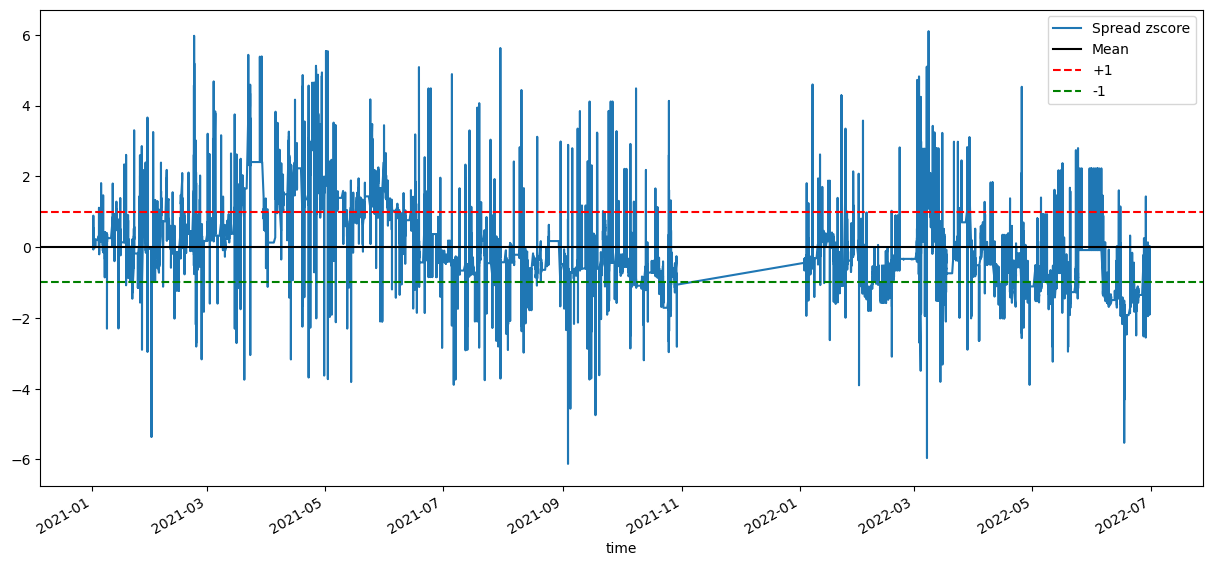

In [24]:
df['spread_zscore'].plot(figsize=(15,7))
plt.axhline(df['spread_zscore'].mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread zscore', 'Mean', '+1', '-1'])
plt.show()

## Better Model

0.002639916042775705


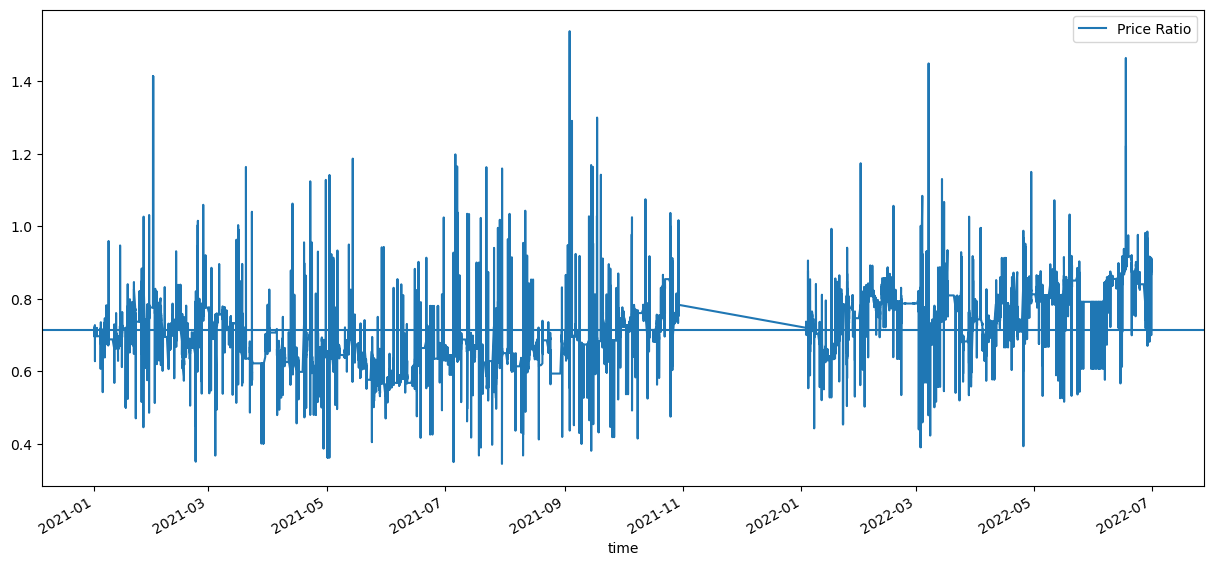

In [25]:
nifty = df['nifty']
banknifty = df['banknifty']
score, pvalue, _ = coint(df['nifty'], df['banknifty'])
print(pvalue)
ratio = nifty / banknifty
ratio.plot(figsize=(15,7))
plt.axhline(ratio.mean())
plt.legend(['Price Ratio'])
plt.show()

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [27]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
    std = ratios.rolling(window=window2,center=False).std()
    
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    track_pnl = []
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
        track_pnl.append(money)
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])

    return money, track_pnl

def zscore(series):
    return (series - series.mean()) / np.std(series)

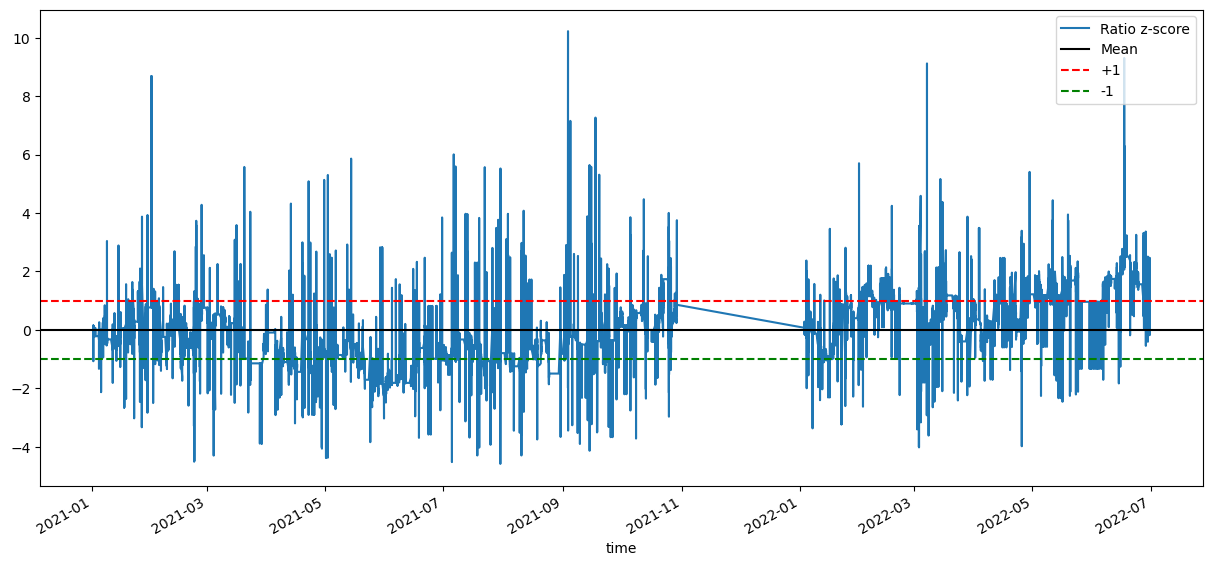

In [28]:
zscore(ratio).plot(figsize=(15,7))
plt.axhline(zscore(ratio).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [29]:
ratio.shape[0]

180856

In [30]:
ratio

time
2021-01-01 09:15:00    0.698212
2021-01-01 09:16:00    0.702333
2021-01-01 09:17:00    0.703662
2021-01-01 09:18:00    0.698558
2021-01-01 09:19:00    0.696756
                         ...   
2022-06-30 15:26:00    0.892219
2022-06-30 15:27:00    0.899049
2022-06-30 15:28:00    0.895417
2022-06-30 15:29:00    0.889203
2022-06-30 15:30:00    0.893236
Length: 180856, dtype: float64

In [31]:
train_size = (ratio.shape[0]*6)//10
print(train_size)

train_data = ratio[:train_size]
test_data = ratio[train_size:]

108513


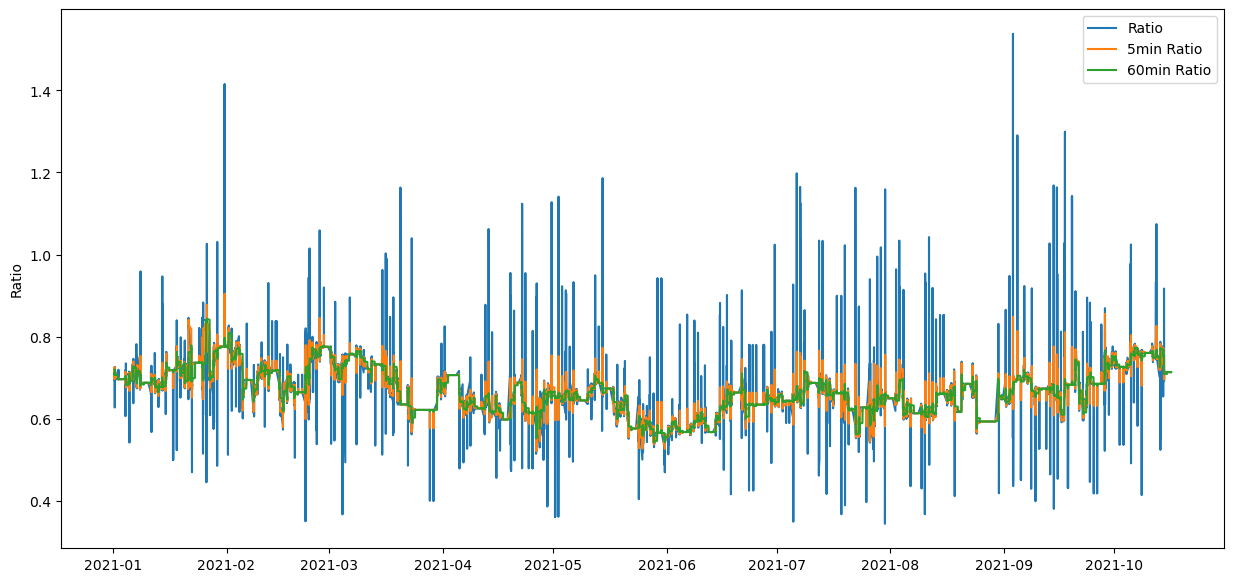

In [32]:
ratio_5 = train_data.rolling(window=5, center=False).mean()

ratio_60 = train_data.rolling(window=60, center=False).mean()

std_5 = train_data.rolling(window=5, center=False).std()

plt.figure(figsize=(15,7))
plt.plot(train_data.index, train_data.values)
plt.plot(ratio_5.index, ratio_5.values)
plt.plot(ratio_60.index, ratio_60.values)

plt.legend(['Ratio','5min Ratio', '60min Ratio'])

plt.ylabel('Ratio')
plt.show()

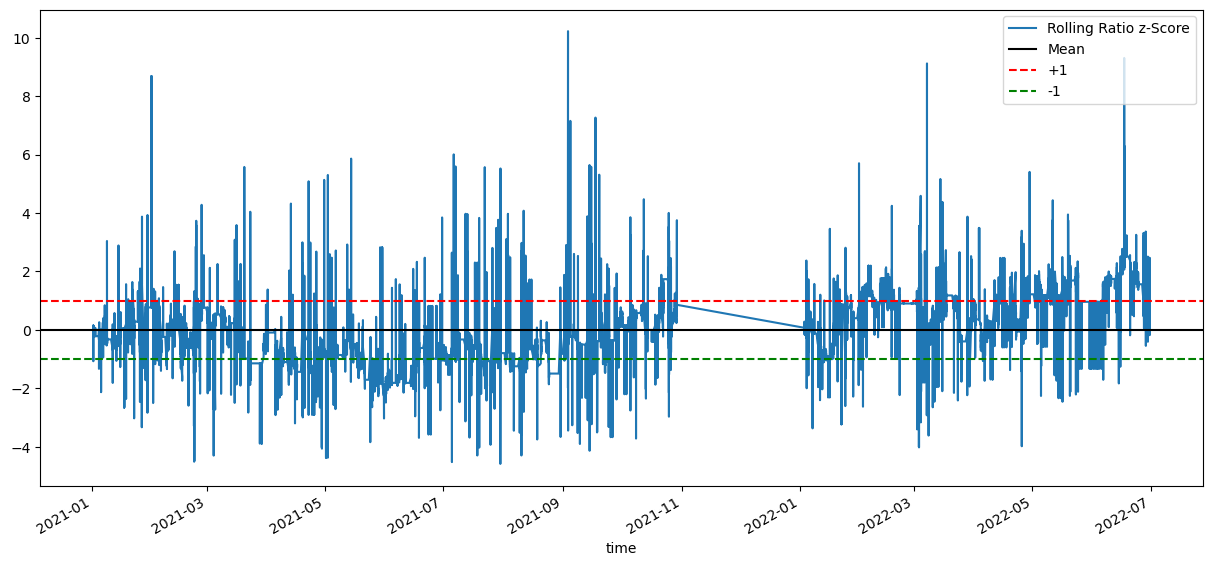

In [33]:
std_60 = train_data.rolling(window=60,center=False).std()
std_60.name = 'std nifty banknifty 60min'

# Compute the z score for each minute
zscore_1 = zscore(ratio)
zscore_1.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [34]:
train_data_PL, train_data_history = trade(df['nifty'][:train_size], df['banknifty'][:train_size], 5, 60)

In [35]:
train_data_PL

52.94005465064473

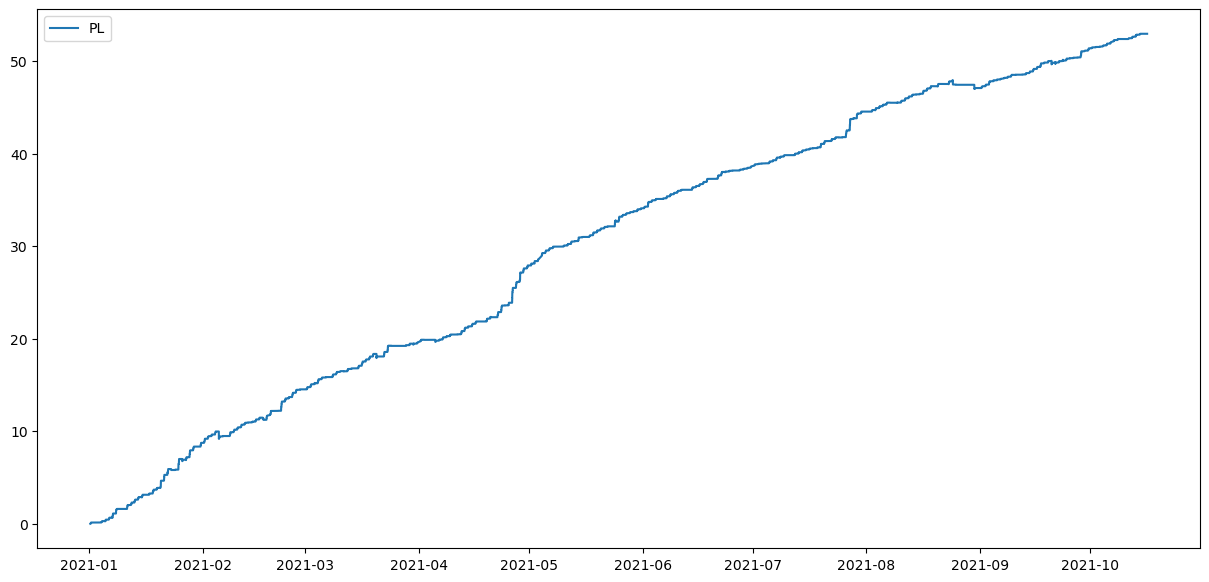

In [36]:
df_train_pnl = pd.DataFrame()
df_train_pnl['PL'] = train_data_history
df_train_pnl.index = df.index[:train_size]
plt.figure(figsize = (15, 7))
plt.plot(df_train_pnl)
plt.legend(["PL"])
plt.show()

###### It looks good, so we could trade this pair

In [37]:
test_data_PL, test_data_history = trade(df['nifty'].iloc[train_size:], df['banknifty'].iloc[train_size:], 5, 60)

In [38]:
test_data_PL

46.21080488160884

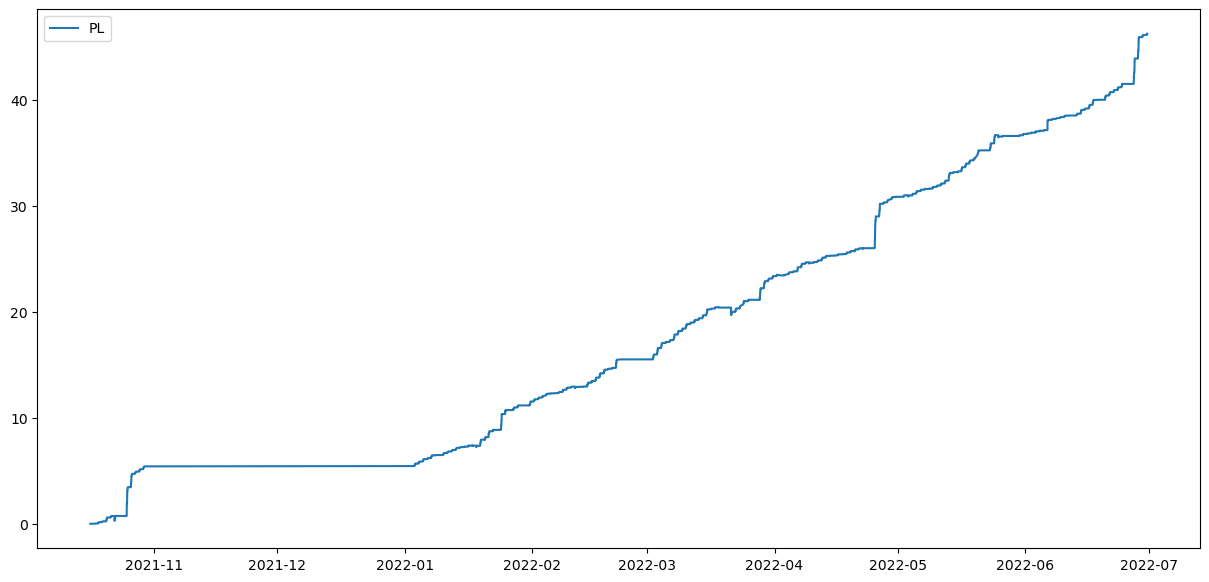

In [39]:
df_test_PL = pd.DataFrame()
df_test_PL['PL'] = test_data_history
df_test_PL.index = df.index[train_size:]
plt.figure(figsize = (15, 7))
plt.plot(df_test_PL)
plt.legend(["PL"])
plt.show()

## Comparison of the Models

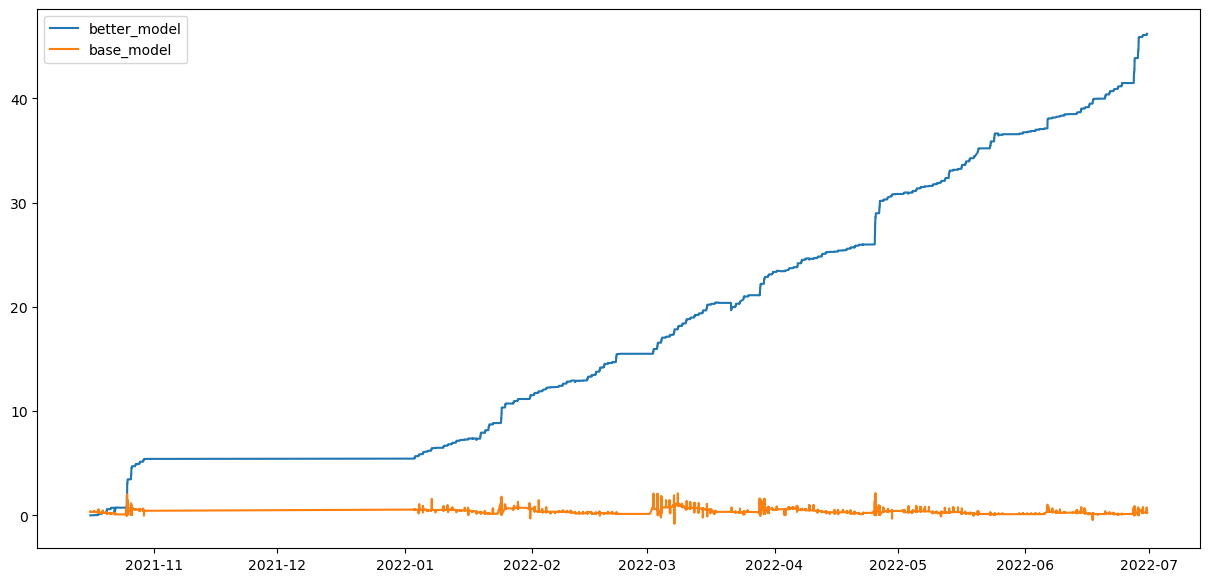

In [40]:
plt.figure(figsize = (15, 7))
plt.plot(df_test_PL)
plt.plot(base_PL[train_size:])
plt.legend(["better_model", "base_model"])
plt.show()

#### We can clearly see that the latter model works better.